In [8]:
import Pkg
Pkg.activate(@__DIR__)
push!(LOAD_PATH, "@macroecon")   


  Activating project at `c:\Users\30945\Desktop\Yuxuan ZHAO\minnesota\PhD_first_year\ECON8107`


5-element Vector{String}:
 "@"
 "@v#.#"
 "@stdlib"
 "@macroecon"
 "@macroecon"

In [1]:
using LinearAlgebra, Statistics
using LaTeXStrings, Plots, QuantEcon

In [2]:
function Household(; r = 0.01,
                   w = 1.0,
                   sigma = 1.0,
                   beta = 0.96,
                   z_chain = MarkovChain([0.9 0.1; 0.1 0.9], [0.1; 1.0]),
                   a_min = 1e-10,
                   a_max = 18.0,
                   a_size = 200,
                   a_vals = range(a_min, a_max, length = a_size),
                   # -Inf is the utility of dying (0 consumption)
                   u = sigma == 1 ? x -> log(x) :
                       x -> (x^(1 - sigma) - 1) / (1 - sigma))

    # Create grids
    z_size = length(z_chain.state_values)
    n = a_size * z_size
    s_vals = gridmake(a_vals, z_chain.state_values)
    s_i_vals = gridmake(1:a_size, 1:z_size)

    # Fill in the Q and R
    Q = zeros(n, a_size, n)
    for next_s_i in 1:size(Q, 3)
        for a_i in 1:size(Q, 2)
            for s_i in 1:size(Q, 1)
                z_i = s_i_vals[s_i, 2]
                next_z_i = s_i_vals[next_s_i, 2]
                next_a_i = s_i_vals[next_s_i, 1]
                if next_a_i == a_i
                    Q[s_i, a_i, next_s_i] = z_chain.p[z_i, next_z_i]
                end
            end
        end
    end

    R = fill(-Inf, n, a_size)
    for new_a_i in 1:size(R, 2)
        a_new = a_vals[new_a_i]
        for s_i in 1:size(R, 1)
            a = s_vals[s_i, 1]
            z = s_vals[s_i, 2]
            c = w * z + (1 + r) * a - a_new
            if c > 0
                R[s_i, new_a_i] = u(c)
            end
        end
    end
    return (; r, w, sigma, beta, z_chain, a_min, a_max, a_size, a_vals, z_size,
            n, s_vals, s_i_vals, u, R, Q)
end

Household (generic function with 1 method)

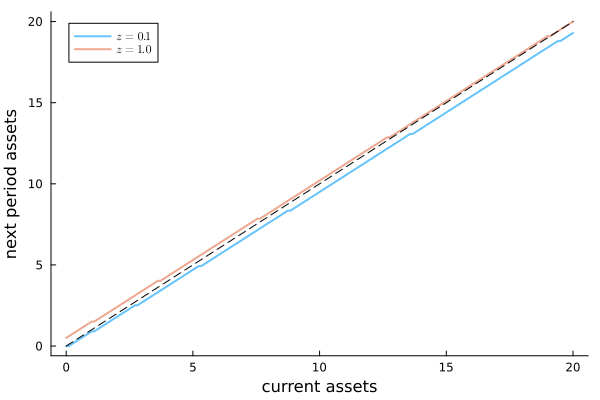

In [3]:
# Create an instance of Household
am = Household(; a_max = 20.0, r = 0.03, w = 0.956)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.beta)

# Solve using policy function iteration
results = solve(am_ddp, PFI)

# Simplify names
(; z_size, a_size, n, a_vals) = am
z_vals = am.z_chain.state_values

# Get all optimal actions across the set of
# a indices with z fixed in each column
a_star = reshape([a_vals[results.sigma[s_i]] for s_i in 1:n], a_size, z_size)

labels = [L"z = %$(z_vals[1])" L"z = %$(z_vals[2])"]
plot(a_vals, a_star, label = labels, lw = 2, alpha = 0.6)
plot!(a_vals, a_vals, label = "", color = :black, linestyle = :dash)
plot!(xlabel = "current assets", ylabel = "next period assets", grid = false)

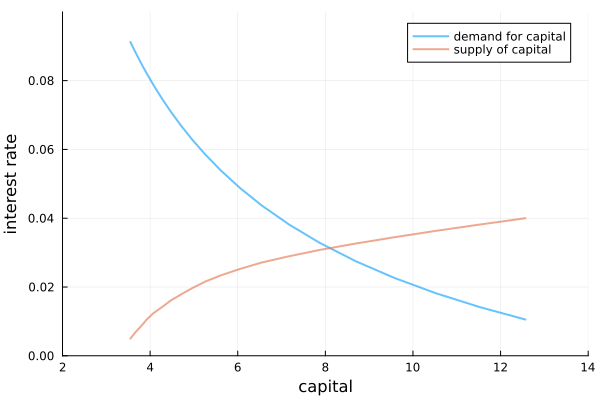

In [4]:
# Calculate supply of capital for a given r
function prices_to_capital_stock(r; beta, A, N, alpha, delta, a_max)
    # Create an instance of Household given the parameters

    # Calculate the equilibrium wages
    w = A * (1 - alpha) * (A * alpha / (r + delta))^(alpha / (1 - alpha))
    am = Household(; beta, a_max, w, r)

    aiyagari_ddp = DiscreteDP(am.R, am.Q, am.beta)

    # Compute the optimal policy
    results = solve(aiyagari_ddp, PFI)

    # Compute the stationary distribution
    stationary_probs = stationary_distributions(results.mc)[:, 1][1]

    # Return K
    K = dot(am.s_vals[:, 1], stationary_probs)

    # Return capital
    return K
end

# Inverse Demand for capital
function r_inverse_demand(K; A, N, alpha, delta)
    return A * alpha * (N / K)^(1 - alpha) - delta
end

# Create a grid of r values at which to compute demand and supply of capital
r_vals = range(0.005, 0.04, length = 20)

# Firms' parameters
A = 1
N = 1
alpha = 0.33
beta = 0.96
delta = 0.05
a_max = 20.0

prices_to_capital_stock(r_vals[1]; A, N, alpha, beta, delta, a_max)

# Compute supply of capital
k_vals = prices_to_capital_stock.(r_vals; A, N, alpha, beta, delta, a_max)

r_inverse_demand_vals = r_inverse_demand.(k_vals; A, N, alpha, delta)

# Plot against demand for capital by firms
labels = ["demand for capital" "supply of capital"]
plot(k_vals, [r_inverse_demand_vals r_vals], label = labels, lw = 2,
     alpha = 0.6)
plot!(xlabel = "capital", ylabel = "interest rate", xlim = (2, 14),
      ylim = (0.0, 0.1))

In [6]:
import Pkg
Pkg.status()


Status `C:\Users\30945\Desktop\Yuxuan ZHAO\minnesota\PhD_first_year\ECON8107\Project.toml`
  [b964fa9f] LaTeXStrings v1.4.0
  [91a5bcdd] Plots v1.41.4
  [fcd29c91] QuantEcon v0.17.1
